# Preliminaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sys.path.append("/Users/paolo/Documents/methods/CMI_FS")
from feature_selection import forwardFeatureSelection

sys.path.append("/Users/paolo/Documents/methods/LinCFA")
from LinCFA import LinCFA

sys.path.append("/Users/paolo/Documents/Droughts/Paolo/regression_LinCFA")
from aux import standardize,unfold_dataset,compute_r2,prepare_target,prepare_features,aggregate_unfolded_data,FS_with_linearWrapper,compare_methods


In [2]:
def plot_cells(output,selected_colnames, xmin=9, xmax=11, ymin=44, ymax=45.5):
    x = []
    y = []
    colors = cm.rainbow(np.linspace(0,1,len(output)))
    np.random.shuffle(colors)
    fig, ax = plt.subplots(2)
    ax[0].set_xlim(xmin,xmax)
    ax[1].set_xlim(xmin,xmax)
    ax[0].set_ylim(ymin,ymax)
    ax[1].set_ylim(ymin,ymax)
    for i in range(len(output)): 
        #print(len(output[i]))
        x = []
        y = []
        
        for datum in output[i]:
            x.append(float(datum.split('_')[1]))
            y.append(float(datum.split('_')[2]))
        ax[0].scatter(x,y,color=colors[i])
    
    x = []
    y = []
    col = cm.rainbow(np.linspace(0,1,len(selected_colnames)))
    for i in range(len(selected_colnames)): 
        idx = int(selected_colnames[i].split('_')[-1])
        for datum in output[idx]:
            x.append(float(datum.split('_')[1]))
            y.append(float(datum.split('_')[2]))
        ax[1].scatter(x,y,color=col[i])
    

In [3]:
### Nota: devo standardizzare tutto prima di chiamare LinCFA ma non serve validare
# infatti il metodo usa i dati per stimare i pesi della regressione lineare
# anche per CMI_FS non serve validare, usa i dati per quantificare l'informazione condivisa col target

# Target 

target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.214281    0.00  2001     1 -1.339879
1    2001-01-13  0.484737    0.52  2001     2  0.402993
2    2001-01-21  0.466071    0.47  2001     3  0.282703
3    2001-01-29  0.417470    0.44  2001     5 -0.030490
4    2001-02-06  0.492202    0.53  2001     6  0.451097
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.436464    0.46  2009    48  0.091910
407  2009-12-05  0.466152    0.49  2009    49  0.283224
408  2009-12-13  0.553659    0.59  2009    50  0.847138
409  2009-12-21  0.507978    0.65  2009    52  0.552758
410  2009-12-29  0.083046    0.00  2009    53 -2.185583

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))


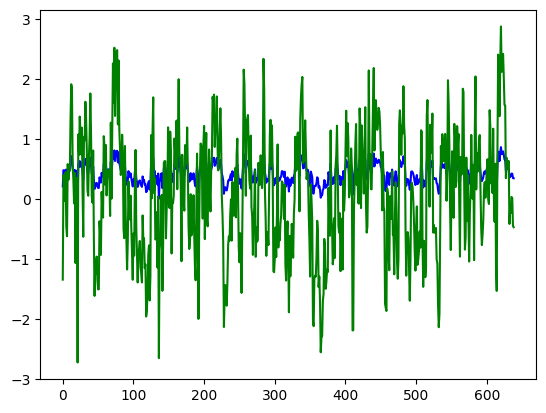

In [4]:
### target stops in 2019
target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
plt.plot(target_df_trainVal.loc[:,'mean'], color='blue')
plt.plot(target_df_trainVal.loc[:,'mean_std'], color='green')

# Features

In [14]:
path='/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/features/csv_allvalues/temporal_aggreg/Emiliani2_aggreg.csv'

df_test_unfolded_std = pd.DataFrame()
df_trainVal_unfolded_std = pd.DataFrame()

for col in ['cyclostationary_mean_tg', 
            'cyclostationary_mean_tg_1w',
            'cyclostationary_mean_tg_4w', 
            'cyclostationary_mean_tg_8w',
            'cyclostationary_mean_tg_12w', 
            'cyclostationary_mean_tg_16w',
            'cyclostationary_mean_tg_24w',
           'cyclostationary_mean_rr', 
            'cyclostationary_mean_rr_1w',
            'cyclostationary_mean_rr_4w', 
            'cyclostationary_mean_rr_8w',
            'cyclostationary_mean_rr_12w', 
            'cyclostationary_mean_rr_16w',
            'cyclostationary_mean_rr_24w']:
    df_train_unfolded_std_loc,df_val_unfolded_std_loc,df_test_unfolded_std_loc,df_trainVal_unfolded_std_loc = prepare_features(path,col,multiple=False,max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
    df_trainVal_unfolded_std_loc = df_trainVal_unfolded_std_loc.add_prefix(col)
    df_trainVal_unfolded_std = pd.concat([df_trainVal_unfolded_std, df_trainVal_unfolded_std_loc], axis=1)
    df_test_unfolded_std_loc = df_test_unfolded_std_loc.add_prefix(col)
    df_test_unfolded_std = pd.concat([df_test_unfolded_std, df_test_unfolded_std_loc], axis=1)
    

In [15]:
df_trainVal_unfolded_std

,cyclostationary_mean_tgmean_10.449860349182202_44.24986054919872,cyclostationary_mean_tgmean_10.449860349182202_44.34986054888138,cyclostationary_mean_tgmean_10.449860349182202_44.44986054856403,cyclostationary_mean_tgmean_10.449860349182202_44.54986054824669,cyclostationary_mean_tgmean_10.449860349182202_44.64986054792934,cyclostationary_mean_tgmean_10.449860349182202_44.749860547612,cyclostationary_mean_tgmean_10.449860349182202_44.849860547294654,cyclostationary_mean_tgmean_10.449860349182202_44.949860546977305,cyclostationary_mean_tgmean_10.549860348782152_44.24986054919872,cyclostationary_mean_tgmean_10.549860348782152_44.34986054888138,...,cyclostationary_mean_rr_24wmean_9.949860351182458_44.849860547294654,cyclostationary_mean_rr_24wmean_9.949860351182458_44.949860546977305,cyclostationary_mean_rr_24wmean_9.949860351182458_45.04986054665997,cyclostationary_mean_rr_24wmean_9.949860351182458_45.14986054634262,cyclostationary_mean_rr_24wmean_9.949860351182458_45.24986054602528,cyclostationary_mean_rr_24wmean_10.949860347181946_44.64986054792934,cyclostationary_mean_rr_24wmean_10.949860347181946_44.749860547612,cyclostationary_mean_rr_24wmean_10.949860347181946_44.849860547294654,cyclostationary_mean_rr_24wmean_10.949860347181946_44.949860546977305,cyclostationary_mean_rr_24wmean_10.949860347181946_45.04986054665997
0,0.289227,0.124864,0.461279,0.510020,0.520576,0.468040,0.540865,0.583502,0.279997,0.160805,...,4.633165,2.023797,3.783344,4.275220,4.804841,1.738511,3.017236,2.808310,3.306185,2.903963
1,1.465288,1.793975,2.180194,2.007116,1.814130,1.577802,1.418296,1.353838,1.387328,1.698076,...,3.258669,2.355244,3.555257,4.218524,4.692536,0.503774,1.109312,1.020964,1.909813,2.003819
2,-1.343176,-1.039494,-0.116039,0.221848,0.163267,-0.104759,-0.347514,-0.401203,-1.511178,-1.118456,...,2.983529,1.626289,2.416648,2.815001,3.107059,0.184162,0.502990,0.333127,0.929751,1.026544
3,1.287995,1.347720,1.854175,1.771276,1.468763,1.169796,0.991305,0.942426,1.224261,1.271877,...,2.228901,1.172727,1.785545,2.045116,2.811179,-0.277898,-0.128053,-0.245722,0.353457,0.482495
4,-0.622729,-0.213143,0.630215,0.751518,0.774634,0.655703,0.430421,0.388102,-0.785567,-0.359637,...,1.434718,0.539199,0.990035,1.190746,1.802918,0.602205,0.513759,0.099714,0.490890,0.185020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,0.636886,0.711674,1.049935,1.116184,0.930652,0.807234,0.667475,0.267026,0.702180,0.753531,...,1.742019,1.503120,1.053123,0.877652,0.823177,-0.210937,0.600039,1.377278,1.335844,1.342198
635,1.506738,0.994676,1.103902,1.077065,1.283393,1.402029,1.346439,1.068840,1.370677,1.001001,...,1.949491,1.763939,1.297141,1.110861,1.040890,-0.235416,0.586727,1.261427,1.311165,1.404041
636,0.489896,0.687257,1.032075,1.038221,1.529280,1.819080,1.779584,1.456675,0.472591,0.852688,...,2.208475,2.078453,1.583455,1.340409,1.289883,-0.187062,0.780202,1.546400,1.666952,1.744398
637,1.003631,1.382055,1.596454,1.503624,1.376863,1.279825,1.111276,0.661906,1.131739,1.264129,...,2.245972,2.128930,1.660883,1.430205,1.359141,-0.073519,1.020794,1.716302,1.763189,1.827166


# temperature

### wrapper

In [20]:
filter_col = [col for col in df_trainVal_unfolded_std if col.startswith('cyclostationary_mean_tg')]

selected_colnames = FS_with_linearWrapper(df_trainVal_unfolded_std[filter_col], target_df_train, target_df_val, 50, 228)

compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames)


actual training score: 0.07878691312828734
actual validation score: 0.26635416025168623, number of remaining columns: 908

actual training score: 0.08403252200039157
actual validation score: 0.2976868002363827, number of remaining columns: 907

actual training score: 0.09848902426272566
actual validation score: 0.31842664444090885, number of remaining columns: 906

actual training score: 0.10328948343164657
actual validation score: 0.33566965708914276, number of remaining columns: 905

actual training score: 0.11249653581445729
actual validation score: 0.3548670543290424, number of remaining columns: 904

actual training score: 0.12592945720095006
actual validation score: 0.36603974541037243, number of remaining columns: 903

actual training score: 0.13272614082228718
actual validation score: 0.38148145351648455, number of remaining columns: 902

actual training score: 0.14013799413632888
actual validation score: 0.39613827638861265, number of remaining columns: 901

actual training sc

Full aggregate regression train score: 1.0, test score: -182.87641719684552
Aggregate regression train score with FS: 0.3682368908212993, test score: -1.17389899353361


In [21]:
compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -182.87641719684552
Aggregate regression train score with FS: 0.2181908433818932, test score: -0.01771755955492571


### CMI FS

In [22]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(df_trainVal_unfolded_std[filter_col]),np.array(target_df_trainVal.mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = df_trainVal_unfolded_std[filter_col].columns[res['selectedFeatures']]
compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames)


----- MI Scores -----
[(203, 0.15246918228231238), (100, 0.14998699676357055), (99, 0.14933536712992324), (104, 0.14860373806543736), (178, 0.1414417335986945), (105, 0.1412488284588791), (202, 0.13829747463732578), (95, 0.13678834355637548), (236, 0.13678309275993097), (194, 0.13581585309537378), (101, 0.1349170730411436), (47, 0.1336253951612861), (106, 0.13270113122246438), (40, 0.13247441716956537), (102, 0.1314947303492075), (196, 0.13126063784810943), (231, 0.13069123294496232), (33, 0.13043798808455945), (225, 0.1302658916389474), (109, 0.13021214040178367), (210, 0.12966293382329977), (249, 0.12917280305281248), (140, 0.12903926454886683), (170, 0.12877226912436), (217, 0.12875304464935164), (171, 0.12798338305707846), (41, 0.12732735510523543), (169, 0.12685101142337496), (149, 0.12671700820733212), (10, 0.12663829279776576), (2, 0.12652023408954435), (209, 0.12614802062441602), (195, 0.1253698529374116), (218, 0.1248562685125378), (177, 0.12479126466694364), (133, 0.124699680

CMI: 0.010000319640472877
CMI: 0.01412939716424727
CMI: 0.009910053872537322
CMI: 0.0017723241759730612
CMI: 0.013488305443276699
CMI: 0.01066837312462049
CMI: 0.0017710394732852741
CMI: 0.0001391606043173177
CMI: 0.001126739583212799
CMI: 0.006318146496627652
Highest CMI score: 0.01412939716424727
Adding original feature: 686
CMI: 0.000696581836224619
CMI: 0.0013254503296828701
CMI: 0.002831402278826195
CMI: 0.0020101518458281176
CMI: 0.006889001988496762
CMI: 0.00734898012552071
CMI: 0.002402172403099645
CMI: 0.0017320635835175457
CMI: 0.0005206357356201397
CMI: 0.003678079604233858
CMI: 0.007463174705151676
CMI: 0.004643994918141853
CMI: 0.0005739969711818227
CMI: 0.0026831558580223125
CMI: 0.00021929104455473136
CMI: 0.009338747435544192
CMI: 0.0017645705672484913
CMI: 0.0057968161160694975
CMI: 9.399335998547254e-05
CMI: 0.0015071540377682158
CMI: 0.0016142497279160173
CMI: 0.00037157958672145996
CMI: 0.00976089049369916
CMI: 0.0014598568791529543
CMI: 0.013799599642415589
CMI: 0.

CMI: 0.00313800476166054
CMI: 0.0023587315143495102
CMI: 0.0005007212887339629
CMI: 0.0015967142945251256
CMI: 0.0027072911066799987
CMI: 0.003655226956641555
CMI: 0.00046161621565782296
CMI: 0.000490799187150115
CMI: 6.0923429766879256e-05
CMI: 0.0020060041944208185
CMI: 0.004958080760055661
Highest CMI score: 0.004958080760055661
Adding original feature: 905
CMI: 6.624389258952368e-05
CMI: 0.004113712073561593
CMI: 0.001041305665715364
CMI: 0.0016699163961597652
CMI: 0.0028403357961696574
CMI: 0.001777572767514779
CMI: 0.0010977924360314195
CMI: 0.0011473157497466913
CMI: 0.0022301616611327124
CMI: 0.0015517169293876032
CMI: 0.0016176959816950887
CMI: 0.0042787252024802935
CMI: 0.0034706611600189285
CMI: 0.0005799724096015035
CMI: 0.003545884789923015
CMI: 0.0012049536045610765
CMI: 0.0002303382674400667
CMI: 0.0002583734700775109
CMI: 0.006309098866222329
CMI: 0.004133243856872915
CMI: 0.0035835591058359095
CMI: 0.002213913066580364
CMI: 0.0013111172762677037
CMI: 0.0035942913688117

In [23]:
compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -182.87641719684552
Aggregate regression train score with FS: 0.15905733756229268, test score: 0.11097319343823331


# precipitation

### wrapper

In [24]:
filter_col = [col for col in df_trainVal_unfolded_std if col.startswith('cyclostationary_mean_rr')]

selected_colnames = FS_with_linearWrapper(df_trainVal_unfolded_std[filter_col], target_df_train, target_df_val, 50, 228)

compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames)


actual training score: 0.09927214633418913
actual validation score: 0.22546677532771253, number of remaining columns: 908

actual training score: 0.11203636858181643
actual validation score: 0.26160613739476024, number of remaining columns: 907

actual training score: 0.12804818513214877
actual validation score: 0.3134292903082103, number of remaining columns: 906

actual training score: 0.13606524641603812
actual validation score: 0.3315681589541455, number of remaining columns: 905

actual training score: 0.14035819023574003
actual validation score: 0.34864991925359723, number of remaining columns: 904

actual training score: 0.1457476367364997
actual validation score: 0.3652504941431016, number of remaining columns: 903

actual training score: 0.1600692845711147
actual validation score: 0.3752056587719943, number of remaining columns: 902

actual training score: 0.17178819884720753
actual validation score: 0.3971622562824825, number of remaining columns: 901

actual training score: 

Full aggregate regression train score: 1.0, test score: -58.76844415524165
Aggregate regression train score with FS: 0.3941580915683611, test score: -0.3342794025196383


In [25]:
compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -58.76844415524165
Aggregate regression train score with FS: 0.23083168074955562, test score: 0.03555923862735799


### CMI FS

In [26]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(df_trainVal_unfolded_std[filter_col]),np.array(target_df_trainVal.mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = df_trainVal_unfolded_std[filter_col].columns[res['selectedFeatures']]
compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames)


----- MI Scores -----
[(423, 0.13605075049878657), (743, 0.13408811036773696), (305, 0.12874077211883111), (292, 0.1277889705384366), (429, 0.1268241207271313), (624, 0.12565636526912266), (392, 0.12452492621420415), (393, 0.12367297249338156), (295, 0.12310963255758561), (437, 0.12290025740920155), (605, 0.12248755184188319), (285, 0.1223588402767927), (396, 0.12235323484187698), (399, 0.12103429801669917), (395, 0.1171140836679901), (424, 0.11643012181832754), (391, 0.11560864900889813), (416, 0.11525545004987721), (403, 0.11409660447037692), (261, 0.11387243468032031), (545, 0.11361780136905607), (477, 0.11359355205974847), (504, 0.11326317160376492), (276, 0.11187737440357741), (389, 0.11139302407482399), (394, 0.11090525764301253), (614, 0.11063661416703183), (498, 0.11049960323962205), (518, 0.11043041274662692), (265, 0.11024335687133625), (275, 0.11016339648278246), (401, 0.11013565806499846), (390, 0.10965961551500343), (267, 0.10945430783486539), (268, 0.10933154474462303), (

CMI: 0.02431068528412844
CMI: 0.0005171327707029494
CMI: 0.023163334586512957
CMI: 0.0163106264242322
CMI: 0.02222453169989244
CMI: 0.01474569672611517
CMI: 0.024826589148426836
CMI: 0.02112279148388621
CMI: 0.006206097719881398
CMI: 0.03979514816675808
CMI: 0.003403265874082323
CMI: 0.008965725428241283
CMI: 0.02076980279122609
CMI: 0.005901657306822183
CMI: 0.0012082142744637703
CMI: 0.03200692436243899
CMI: 0.007477089884503019
CMI: 0.020059827377095413
CMI: 0.02648021986101856
CMI: 0.029037781099450682
CMI: 0.02749023585622845
CMI: 0.0022437226024129286
CMI: 0.0024735229830760708
CMI: 0.007235409048122338
CMI: 0.021748684495330683
CMI: 0.034692259028920786
CMI: 0.031244060589909917
CMI: 0.0032704974699931666
CMI: 0.006124450520107905
CMI: 0.01657988147570008
CMI: 0.024806664704185494
CMI: 0.003955434679103698
CMI: 0.008123394834670311
CMI: 0.02409622399928793
CMI: 0.010709434814785396
CMI: 0.014038079032844375
CMI: 0.009523223573736278
CMI: 0.022812052806249178
CMI: 0.0129787016069

CMI: 0.030893940395761543
CMI: 0.02117441030212569
CMI: 0.006246142348531575
CMI: 0.014566936283515464
CMI: 0.01665489491544503
CMI: 0.028285873767485203
CMI: 0.006580433342089548
CMI: 0.006273310920720837
CMI: 0.024137250729006077
CMI: 0.0022969680751089294
CMI: 0.004039390675141863
CMI: 0.02483480910424568
CMI: 0.019862439987997943
CMI: 0.01964029710425297
CMI: 0.006298932436487298
CMI: 0.021330064932956472
CMI: 0.018999486403348087
CMI: 0.008463061892881846
CMI: 0.014824175321343808
CMI: 0.02163114896820248
CMI: 0.01778467860797664
CMI: 0.03862674754855416
CMI: 0.014392340853373597
CMI: 0.013289077906607993
CMI: 0.016375599164601934
CMI: 0.0014124670054050104
CMI: 0.013422260085236726
CMI: 0.017355845385790047
CMI: 0.012352799668791464
CMI: 0.003795977895842101
CMI: 0.025890509108985632
CMI: 0.005354637664460926
CMI: 0.008509891344959442
CMI: 0.004228771227987177
CMI: 0.0013892242373682029
CMI: 0.02242208120779099
CMI: 0.00688614600712556
CMI: 0.02000717174219077
CMI: 0.004443139384

CMI: 0.002602151008803455
CMI: 0.002809339770570768
CMI: 0.0031185004680575057
CMI: 0.0015065995266630161
CMI: 0.0011559637826372704
CMI: 0.00011191401751425856
CMI: 0.0013388619004484348
CMI: 0.0050446562269533535
CMI: 3.344470174013181e-05
CMI: 0.006223581259837324
CMI: 0.00014159800769233954
CMI: 0.001312471579509783
CMI: 0.002654246978139402
CMI: 0.0015359272608092
CMI: 0.0013273386019133637
CMI: 0.0017218441899385095
CMI: 0.0020636853120670207
CMI: 0.008156441841341872
CMI: 0.000445897866676509
CMI: 0.0008876982305124348
CMI: 0.00025269467679145396
CMI: 7.463540887830966e-05
CMI: 0.0020573855043315437
CMI: 0.00031093050320346594
Highest CMI score: 0.008156441841341872
Adding original feature: 613
CMI: 0.004043509310391491
CMI: 0.0033839280382585435
CMI: 0.0002724123882908991
CMI: 0.002492124327916234
CMI: 0.0017262154244034322
CMI: 0.00018127134938300538
CMI: 3.165009814620756e-06
CMI: 0.004569452321990353
CMI: 0.001811592819201513
CMI: 0.0030900345349413882
CMI: 0.000581908835718

In [27]:
compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -58.76844415524165
Aggregate regression train score with FS: 0.1086379623973337, test score: 0.027791826254386698


# temperature and precipitation

### wrapper

In [28]:
selected_colnames = FS_with_linearWrapper(df_trainVal_unfolded_std, target_df_train, target_df_val, 50, 228)

compare_methods(df_trainVal_unfolded_std, df_test_unfolded_std, target_df_trainVal, target_df_test, selected_colnames)


actual training score: 0.0922091204186467
actual validation score: 0.34173117881476334, number of remaining columns: 1818

actual training score: 0.12210603706280387
actual validation score: 0.382338233404963, number of remaining columns: 1817

actual training score: 0.15338953449123216
actual validation score: 0.4267901706739665, number of remaining columns: 1816

actual training score: 0.1583755410498099
actual validation score: 0.4493029331019901, number of remaining columns: 1815

actual training score: 0.1626896235397386
actual validation score: 0.47436622509405246, number of remaining columns: 1814

actual training score: 0.17077585594550648
actual validation score: 0.4952757502606995, number of remaining columns: 1813

actual training score: 0.1736025030847852
actual validation score: 0.5088944235693655, number of remaining columns: 1812

actual training score: 0.18633524495264198
actual validation score: 0.5365578528576661, number of remaining columns: 1811

actual training sco

Full aggregate regression train score: 1.0, test score: -8.24796108023971
Aggregate regression train score with FS: 0.4228716554642401, test score: -0.8346909161993972


In [29]:
compare_methods(df_trainVal_unfolded_std, df_test_unfolded_std, target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -8.24796108023971
Aggregate regression train score with FS: 0.28593689082389273, test score: 0.2375350034843443


### repeat both with CMI FS

In [30]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(df_trainVal_unfolded_std),np.array(target_df_trainVal.mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = df_trainVal_unfolded_std.columns[res['selectedFeatures']]
compare_methods(df_trainVal_unfolded_std, df_test_unfolded_std, target_df_trainVal, target_df_test, selected_colnames)


----- MI Scores -----
[(203, 0.15246918228231238), (100, 0.14998699676357055), (99, 0.14933536712992324), (104, 0.14860373806543736), (178, 0.1414417335986945), (105, 0.1412488284588791), (202, 0.13829747463732578), (95, 0.13678834355637548), (236, 0.13678309275993097), (1333, 0.13605075049878657), (194, 0.13581585309537378), (101, 0.1349170730411436), (1653, 0.13408811036773696), (47, 0.1336253951612861), (106, 0.13270113122246438), (40, 0.13247441716956537), (102, 0.1314947303492075), (196, 0.13126063784810943), (231, 0.13069123294496232), (33, 0.13043798808455945), (225, 0.1302658916389474), (109, 0.13021214040178367), (210, 0.12966293382329977), (249, 0.12917280305281248), (140, 0.12903926454886683), (170, 0.12877226912436), (217, 0.12875304464935164), (1215, 0.12874077211883111), (171, 0.12798338305707846), (1202, 0.1277889705384366), (41, 0.12732735510523543), (169, 0.12685101142337496), (1339, 0.1268241207271313), (149, 0.12671700820733212), (10, 0.12663829279776576), (2, 0.1265

CMI: 0.010000319640472877
CMI: 0.01412939716424727
CMI: 0.009910053872537322
CMI: 0.0017723241759730612
CMI: 0.013488305443276699
CMI: 0.01066837312462049
CMI: 0.0017710394732852741
CMI: 0.0001391606043173177
CMI: 0.001126739583212799
CMI: 0.006318146496627652
CMI: 0.018469644675450425
CMI: 0.00871567180082844
CMI: 0.01338558726160824
CMI: 0.015082486273071044
CMI: 0.003151937112891273
CMI: 0.010384168050938392
CMI: 0.002056480713120923
CMI: 0.002185858509828026
CMI: 0.00621581430049889
CMI: 0.003173695655592529
CMI: 0.011650036141595765
CMI: 0.006196949465668122
CMI: 0.013175208376939557
CMI: 0.009742034184175047
CMI: 0.0187504752627643
CMI: 0.011371246879013253
CMI: 0.0107282052593492
CMI: 0.006946357694906896
CMI: 0.004999696998542663
CMI: 0.004044232037427764
CMI: 0.000701983630520514
CMI: 0.0010371655733641683
CMI: 0.00110856920787758
CMI: 0.010212426324815893
CMI: 0.0016337322062491555
CMI: 0.009374085513106784
CMI: 0.003556495600974402
CMI: 0.013474738814450937
CMI: 0.0130158922

CMI: 0.039499657594592064
CMI: 0.03689312555513413
CMI: 0.025734825760017982
CMI: 0.01472460644168852
CMI: 0.024939214327472814
CMI: 0.021592324382308098
CMI: 0.046412752473072194
CMI: 0.02004656705242705
CMI: 0.029524212755330348
CMI: 0.010761007352425772
CMI: 0.003822296485183785
CMI: 0.0007231937716546954
CMI: 0.008289743710561653
CMI: 0.04117083284619702
CMI: 0.03453636271199645
CMI: 0.02538094045419645
CMI: 0.018418267046781317
CMI: 0.023188727683043503
CMI: 0.027067902296525226
CMI: 0.004427077065856766
CMI: 0.013686670108873256
CMI: 0.009964132908446194
CMI: 0.022811800499803886
CMI: 0.010199123764759455
CMI: 0.04092600321069356
CMI: 0.018082524528763272
CMI: 0.011307545229953198
CMI: 0.017061767927918053
CMI: 0.024178182784361124
CMI: 0.026597773832809396
CMI: 0.039096370969060906
CMI: 0.030694668265060315
CMI: 0.006779096016528097
CMI: 0.013823030251302854
CMI: 0.008107462115873404
CMI: 0.024169631205521985
CMI: 0.05337737826323305
CMI: 0.028449750157894693
CMI: 0.012799170506

CMI: 0.020571349390245713
CMI: 0.014677875901695225
CMI: 0.00843065204363716
CMI: 0.009494814209068447
CMI: 0.01683924253218555
CMI: 0.015494521008021928
CMI: 0.005963719459675887
CMI: 0.005279610626254899
CMI: 0.012585933930318566
CMI: 0.0014438905532394852
CMI: 0.0002768696134856641
CMI: 0.005335880120496683
CMI: 0.0036111008109954434
CMI: 0.006142872121917858
CMI: 0.006916787696703758
CMI: 0.0003888958972447232
CMI: 0.005972521709049439
CMI: 3.6944213448908414e-05
CMI: 0.012182529582457274
CMI: 0.001576467425868311
CMI: 0.00255596670084815
CMI: 0.0018738902035374816
CMI: 0.007756527038358552
CMI: 0.0019735677319209777
CMI: 0.002658066416069832
CMI: 0.008601337932726466
CMI: 0.002515465304718245
CMI: 0.002384704745567734
CMI: 0.007847608792306948
CMI: 0.007744248066722609
CMI: 0.0031748358653462816
CMI: 0.0006092224647454014
CMI: 0.0037356764239957208
CMI: 0.0005719524350384364
CMI: 0.014666839076198118
CMI: 0.005111478588179924
CMI: 0.007067906403214891
CMI: 0.017963423168658343
CMI

In [31]:
compare_methods(df_trainVal_unfolded_std, df_test_unfolded_std, target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -8.24796108023971
Aggregate regression train score with FS: 0.21940082903467772, test score: 0.2693337585427372


# Shuffle

## Prepare data

In [32]:
target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
target_df_full = pd.concat([target_df_trainVal,target_df_test],axis=0)
target_df_full

target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.214281    0.00  2001     1 -1.339879
1    2001-01-13  0.484737    0.52  2001     2  0.402993
2    2001-01-21  0.466071    0.47  2001     3  0.282703
3    2001-01-29  0.417470    0.44  2001     5 -0.030490
4    2001-02-06  0.492202    0.53  2001     6  0.451097
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.436464    0.46  2009    48  0.091910
407  2009-12-05  0.466152    0.49  2009    49  0.283224
408  2009-12-13  0.553659    0.59  2009    50  0.847138
409  2009-12-21  0.507978    0.65  2009    52  0.552758
410  2009-12-29  0.083046    0.00  2009    53 -2.185583

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))


,date,mean,median,year,week,mean_std
0,2001-01-05,0.214281,0.00,2001,1,-1.339879
1,2001-01-13,0.484737,0.52,2001,2,0.402993
2,2001-01-21,0.466071,0.47,2001,3,0.282703
3,2001-01-29,0.417470,0.44,2001,5,-0.030490
4,2001-02-06,0.492202,0.53,2001,6,0.451097
...,...,...,...,...,...,...
862,2019-11-23,0.707366,0.76,2019,47,1.837653
863,2019-12-01,0.478972,0.50,2019,48,0.365839
864,2019-12-09,0.369868,0.40,2019,50,-0.337246
865,2019-12-17,0.496676,0.53,2019,51,0.479927


In [33]:
path='/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/features/csv_allvalues/temporal_aggreg/Emiliani2_aggreg.csv'

df_test_unfolded_std = pd.DataFrame()
df_trainVal_unfolded_std = pd.DataFrame()

for col in ['cyclostationary_mean_tg', 
            'cyclostationary_mean_tg_1w',
            'cyclostationary_mean_tg_4w', 
            'cyclostationary_mean_tg_8w',
            'cyclostationary_mean_tg_12w', 
            'cyclostationary_mean_tg_16w',
            'cyclostationary_mean_tg_24w',
           'cyclostationary_mean_rr', 
            'cyclostationary_mean_rr_1w',
            'cyclostationary_mean_rr_4w', 
            'cyclostationary_mean_rr_8w',
            'cyclostationary_mean_rr_12w', 
            'cyclostationary_mean_rr_16w',
            'cyclostationary_mean_rr_24w']:
    df_train_unfolded_std_loc,df_val_unfolded_std_loc,df_test_unfolded_std_loc,df_trainVal_unfolded_std_loc = prepare_features(path,col,multiple=False,max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
    df_trainVal_unfolded_std_loc = df_trainVal_unfolded_std_loc.add_prefix(col)
    df_trainVal_unfolded_std = pd.concat([df_trainVal_unfolded_std, df_trainVal_unfolded_std_loc], axis=1)
    df_test_unfolded_std_loc = df_test_unfolded_std_loc.add_prefix(col)
    df_test_unfolded_std = pd.concat([df_test_unfolded_std, df_test_unfolded_std_loc], axis=1)
    
df_full_unfolded_std = pd.concat([df_trainVal_unfolded_std, df_test_unfolded_std], axis=0).reset_index(drop=True)
df_full_unfolded_std


,cyclostationary_mean_tgmean_10.449860349182202_44.24986054919872,cyclostationary_mean_tgmean_10.449860349182202_44.34986054888138,cyclostationary_mean_tgmean_10.449860349182202_44.44986054856403,cyclostationary_mean_tgmean_10.449860349182202_44.54986054824669,cyclostationary_mean_tgmean_10.449860349182202_44.64986054792934,cyclostationary_mean_tgmean_10.449860349182202_44.749860547612,cyclostationary_mean_tgmean_10.449860349182202_44.849860547294654,cyclostationary_mean_tgmean_10.449860349182202_44.949860546977305,cyclostationary_mean_tgmean_10.549860348782152_44.24986054919872,cyclostationary_mean_tgmean_10.549860348782152_44.34986054888138,...,cyclostationary_mean_rr_24wmean_9.949860351182458_44.849860547294654,cyclostationary_mean_rr_24wmean_9.949860351182458_44.949860546977305,cyclostationary_mean_rr_24wmean_9.949860351182458_45.04986054665997,cyclostationary_mean_rr_24wmean_9.949860351182458_45.14986054634262,cyclostationary_mean_rr_24wmean_9.949860351182458_45.24986054602528,cyclostationary_mean_rr_24wmean_10.949860347181946_44.64986054792934,cyclostationary_mean_rr_24wmean_10.949860347181946_44.749860547612,cyclostationary_mean_rr_24wmean_10.949860347181946_44.849860547294654,cyclostationary_mean_rr_24wmean_10.949860347181946_44.949860546977305,cyclostationary_mean_rr_24wmean_10.949860347181946_45.04986054665997
0,0.289227,0.124864,0.461279,0.510020,0.520576,0.468040,0.540865,0.583502,0.279997,0.160805,...,4.633165,2.023797,3.783344,4.275220,4.804841,1.738511,3.017236,2.808310,3.306185,2.903963
1,1.465288,1.793975,2.180194,2.007116,1.814130,1.577802,1.418296,1.353838,1.387328,1.698076,...,3.258669,2.355244,3.555257,4.218524,4.692536,0.503774,1.109312,1.020964,1.909813,2.003819
2,-1.343176,-1.039494,-0.116039,0.221848,0.163267,-0.104759,-0.347514,-0.401203,-1.511178,-1.118456,...,2.983529,1.626289,2.416648,2.815001,3.107059,0.184162,0.502990,0.333127,0.929751,1.026544
3,1.287995,1.347720,1.854175,1.771276,1.468763,1.169796,0.991305,0.942426,1.224261,1.271877,...,2.228901,1.172727,1.785545,2.045116,2.811179,-0.277898,-0.128053,-0.245722,0.353457,0.482495
4,-0.622729,-0.213143,0.630215,0.751518,0.774634,0.655703,0.430421,0.388102,-0.785567,-0.359637,...,1.434718,0.539199,0.990035,1.190746,1.802918,0.602205,0.513759,0.099714,0.490890,0.185020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.135936,0.335653,0.590066,0.690449,0.908015,0.920405,0.872771,0.747806,0.026023,0.374515,...,2.003750,2.491856,2.217545,2.102998,1.959955,1.218923,1.958634,2.076693,2.310188,2.141091
863,0.703901,1.151028,1.481872,1.587916,2.101657,2.181060,2.077229,1.983884,0.701685,1.175159,...,1.991310,2.573594,2.286006,2.140075,2.033249,0.935874,1.634227,1.730753,2.067592,1.957351
864,0.715264,0.646292,0.809469,0.809123,1.186784,1.194561,1.113647,1.134730,0.553282,0.672209,...,1.814384,2.413185,2.097985,1.908793,1.839248,0.682806,1.318462,1.340780,1.610384,1.554436
865,-0.494025,0.178697,0.523760,0.689497,1.280804,1.319110,1.202701,1.085489,-0.464753,0.117526,...,1.185108,1.797660,1.678862,1.562060,1.492873,0.390046,1.027923,0.949661,1.053536,1.046231


In [34]:
full_df = df_full_unfolded_std.join(target_df_full.loc[:,'mean'])
full_df = full_df.sample(frac=1,random_state=42).reset_index().iloc[:,1:]
full_df = (full_df-full_df[0:411].mean())/full_df[0:411].std()
full_df = full_df.rename(columns={'mean':'mean_std'})
full_df

,cyclostationary_mean_tgmean_10.449860349182202_44.24986054919872,cyclostationary_mean_tgmean_10.449860349182202_44.34986054888138,cyclostationary_mean_tgmean_10.449860349182202_44.44986054856403,cyclostationary_mean_tgmean_10.449860349182202_44.54986054824669,cyclostationary_mean_tgmean_10.449860349182202_44.64986054792934,cyclostationary_mean_tgmean_10.449860349182202_44.749860547612,cyclostationary_mean_tgmean_10.449860349182202_44.849860547294654,cyclostationary_mean_tgmean_10.449860349182202_44.949860546977305,cyclostationary_mean_tgmean_10.549860348782152_44.24986054919872,cyclostationary_mean_tgmean_10.549860348782152_44.34986054888138,...,cyclostationary_mean_rr_24wmean_9.949860351182458_44.949860546977305,cyclostationary_mean_rr_24wmean_9.949860351182458_45.04986054665997,cyclostationary_mean_rr_24wmean_9.949860351182458_45.14986054634262,cyclostationary_mean_rr_24wmean_9.949860351182458_45.24986054602528,cyclostationary_mean_rr_24wmean_10.949860347181946_44.64986054792934,cyclostationary_mean_rr_24wmean_10.949860347181946_44.749860547612,cyclostationary_mean_rr_24wmean_10.949860347181946_44.849860547294654,cyclostationary_mean_rr_24wmean_10.949860347181946_44.949860546977305,cyclostationary_mean_rr_24wmean_10.949860347181946_45.04986054665997,mean_std
0,-1.907532,-1.682061,-1.636837,-1.447221,-1.651621,-1.789657,-1.773938,-1.765519,-1.827034,-1.522062,...,0.467340,0.110702,0.179932,0.224621,1.388448,1.369248,0.990617,1.185566,1.298775,-0.661044
1,-0.139650,0.373559,0.330876,0.368704,0.376525,0.559680,0.404679,0.007378,-0.105782,0.473611,...,0.821365,0.905610,0.875295,0.813788,0.240540,0.475141,0.635070,0.507644,0.646632,-0.297584
2,1.452839,0.925917,0.919736,0.774817,1.369399,1.681362,1.919478,2.097916,1.405686,0.969203,...,-0.868253,-0.750981,-0.704091,-0.480352,-1.177205,-1.158143,-0.854723,-0.670489,-0.448920,-0.429146
3,0.813751,0.551454,0.612530,0.605539,0.891466,1.201659,1.244624,1.265765,0.937093,0.538183,...,-0.475501,-0.346001,-0.296043,-0.388734,-0.931846,-0.710459,-0.850145,-0.865496,-0.765488,-0.764523
4,1.101256,1.270600,1.431554,1.573412,1.378359,1.249166,0.961226,0.828510,1.117718,1.356833,...,0.242784,0.093281,0.058007,0.089719,-0.180970,-0.340571,-0.323323,-0.326758,-0.225681,-0.775203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,1.066725,0.846112,0.655526,0.487559,0.886012,1.006498,1.057889,1.193508,0.934124,0.699974,...,-0.636561,-0.649436,-0.739055,-0.748186,-0.129125,-0.012792,-0.201209,-0.338636,-0.512676,-1.532354
863,0.250601,0.267136,0.276058,0.286012,0.473997,0.685578,0.792447,0.896260,0.567198,0.309232,...,-0.619819,-0.358987,-0.197966,-0.251459,-0.614689,-0.950684,-0.897719,-0.584296,-0.998917,-0.601107
864,0.033176,0.281860,0.420926,0.420118,0.875294,1.001942,0.952190,0.886205,0.085078,0.256182,...,1.035555,0.741548,0.687586,0.673549,0.674124,0.891023,0.671879,0.851331,0.851791,0.320812
865,1.251260,1.108290,1.103918,1.209919,1.118452,1.008791,0.958105,0.923778,1.072212,1.192201,...,1.768794,2.023485,2.018493,1.880126,1.221645,1.344851,1.351946,1.263630,1.378212,0.595229


## Temperature

In [36]:
filter_col = [col for col in full_df if col.startswith('cyclostationary_mean_tg')]

selected_colnames = FS_with_linearWrapper(full_df.loc[0:638,filter_col], full_df.iloc[0:411,:], full_df.loc[411:638,:], 50, 228)

compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


actual training score: 0.15512500507853522
actual validation score: 0.1205826041830047, number of remaining columns: 908

actual training score: 0.15817946333564903
actual validation score: 0.13884439924010517, number of remaining columns: 907

actual training score: 0.16525764681228383
actual validation score: 0.14919034322606772, number of remaining columns: 906

actual training score: 0.27655402641925375
actual validation score: 0.22638645457531303, number of remaining columns: 905

actual training score: 0.27986081419005815
actual validation score: 0.23649314726968917, number of remaining columns: 904

actual training score: 0.2895502612608326
actual validation score: 0.2445052196623616, number of remaining columns: 903

actual training score: 0.29269344684741994
actual validation score: 0.25602315777354656, number of remaining columns: 902

actual training score: 0.2947878759576623
actual validation score: 0.2666478498644529, number of remaining columns: 901

actual training score

Full aggregate regression train score: 1.0, test score: -2.9003142951664485
Aggregate regression train score with FS: 0.4912726430443155, test score: 0.23065645218464303


In [37]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -2.9003142951664485
Aggregate regression train score with FS: 0.2680443374716325, test score: 0.1432819405494712


In [38]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(full_df.loc[0:638,filter_col]),np.array(full_df.loc[0:638,:].mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = full_df.loc[0:638,filter_col].columns[res['selectedFeatures']]
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


----- MI Scores -----
[(236, 0.14388792193222302), (177, 0.1418890182665722), (169, 0.13629240923225042), (100, 0.13115146225433175), (232, 0.1303431528293723), (196, 0.1297294899131267), (195, 0.12845216866760814), (193, 0.1268976974219021), (203, 0.12580627656537618), (47, 0.12529854451293632), (231, 0.1252232462058393), (217, 0.1250610344938418), (235, 0.12437781063443824), (234, 0.12389104647045375), (95, 0.12343394313917598), (178, 0.1233584458937289), (225, 0.12314166413941849), (230, 0.1230284224584577), (101, 0.12251843052558677), (94, 0.1222125388372185), (211, 0.12163778317080376), (222, 0.12137507721652883), (98, 0.1206570669145491), (194, 0.12052098765551447), (173, 0.1204573685556812), (149, 0.1203969572247831), (163, 0.12035304752883529), (131, 0.12012287902779228), (132, 0.11925275975186388), (238, 0.11883855729483714), (141, 0.11879378740793703), (36, 0.11801804592178936), (157, 0.1177705407319474), (150, 0.1177197148665018), (218, 0.11741176112885526), (237, 0.11630668

CMI: 0.013361200468018891
CMI: 0.00010080812437185394
CMI: 0.011646731628115553
CMI: 0.0005673646034732027
CMI: 0.007444350430078517
CMI: 0.0007312601967232046
CMI: 0.0014507136726987224
CMI: 0.0020196081218745443
CMI: 0.0010442734448742885
CMI: 0.0018145151897447365
CMI: 0.008490415670462798
CMI: 0.0012523448993318198
CMI: 0.004055823497930849
CMI: 0.005825842501130024
CMI: 0.0013722550079612317
CMI: 0.010653277282838075
CMI: 0.013293878052951041
CMI: 0.0007537940032025514
CMI: 0.0033623321924105554
CMI: 0.013946881234336156
CMI: 0.0004502288107489649
CMI: 0.0008024626406906155
CMI: 0.0002723499407814023
CMI: 0.0010740662901757292
CMI: 0.013190136933898672
CMI: 0.02259822388366811
CMI: 0.0018061865898782448
CMI: 0.007534947006196613
CMI: 0.01425823403406315
CMI: 0.0049383345350587915
CMI: 0.014627111604391757
CMI: 0.006585350784884397
CMI: 0.0017162570710474723
CMI: 0.008125015653582923
CMI: 0.0028060842488203397
CMI: 0.005675050524241748
CMI: 0.00830123646387615
CMI: 0.00703070112410

CMI: 0.0035606000858817988
CMI: 0.0035485185581564105
CMI: 0.011357563303100587
CMI: 0.0066650393603792935
CMI: 0.00015282791131951412
CMI: 0.0006804424487895089
CMI: 0.002708097902965473
CMI: 0.0008432126937964746
CMI: 0.004277236811546681
CMI: 0.0026335438525864063
CMI: 0.002471492998833563
CMI: 0.0028461449179503495
CMI: 0.008650547085638116
CMI: 0.003378507411082754
CMI: 0.0038116788741404117
CMI: 0.006622195859272179
CMI: 0.0035628502649663885
CMI: 0.0031329770823207426
CMI: 0.0021388937278613573
CMI: 0.009212664005452564
CMI: 0.007877171208022282
CMI: 0.0020167619760771693
CMI: 0.004246233613350414
CMI: 0.0033649634335337353
CMI: 0.0013717258961551126
CMI: 0.0013705588753884501
CMI: 0.0027875234768456603
CMI: 0.002450043214830694
CMI: 0.004593367777452839
CMI: 0.0030435598916854767
CMI: 0.0011250965515594014
CMI: 0.0009448796343157484
CMI: 0.00024162853118478433
CMI: 0.00010124804307223845
CMI: 0.001388109201059251
CMI: 0.0002285010072349547
CMI: 0.0014633444240400306
CMI: 0.0016

In [39]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -2.9003142951664485
Aggregate regression train score with FS: 0.24009882432053697, test score: 0.1587335906876256


## Precipitation

In [40]:
filter_col = [col for col in full_df if col.startswith('cyclostationary_mean_rr')]

selected_colnames = FS_with_linearWrapper(full_df.loc[0:638,filter_col], full_df.iloc[0:411,:], full_df.loc[411:638,:], 50, 228)

compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


actual training score: 0.17053889285001844
actual validation score: 0.17905429661719385, number of remaining columns: 908

actual training score: 0.1842944441624359
actual validation score: 0.20931024333535309, number of remaining columns: 907

actual training score: 0.20747109931772034
actual validation score: 0.23301251628872033, number of remaining columns: 906

actual training score: 0.21358597946722624
actual validation score: 0.24310629015036778, number of remaining columns: 905

actual training score: 0.23107273749152546
actual validation score: 0.2759613567894401, number of remaining columns: 904

actual training score: 0.23480699187474263
actual validation score: 0.29545775539453534, number of remaining columns: 903

actual training score: 0.24288758109732989
actual validation score: 0.3119418235517215, number of remaining columns: 902

actual training score: 0.25022643863006633
actual validation score: 0.3270051228106492, number of remaining columns: 901

actual training scor

Full aggregate regression train score: 1.0, test score: -3.843031438303554
Aggregate regression train score with FS: 0.4124446062381293, test score: 0.06330975302072761


In [41]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -3.843031438303554
Aggregate regression train score with FS: 0.22374664390873988, test score: 0.12153402049931239


In [42]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(full_df.loc[0:638,filter_col]),np.array(full_df.loc[0:638,:].mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = full_df.loc[0:638,filter_col].columns[res['selectedFeatures']]
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


----- MI Scores -----
[(649, 0.12027709398524908), (477, 0.11863617481351948), (416, 0.1151789620771412), (392, 0.11388975705527218), (264, 0.10945048727011458), (538, 0.10808018843436287), (661, 0.10547893717180057), (185, 0.10526816832995362), (423, 0.10409374748079935), (144, 0.10399867253686343), (274, 0.10381263370125109), (638, 0.10333914152933496), (267, 0.10308773146685533), (545, 0.10293924900335188), (429, 0.10245190610427503), (279, 0.10112581475700931), (169, 0.10058344832096203), (618, 0.10052328866505997), (295, 0.10042075577155578), (2, 0.09959459719637279), (539, 0.09922245527309131), (297, 0.09921447222704408), (137, 0.09881468675239001), (519, 0.09870533874937279), (136, 0.09860748749680497), (437, 0.0981225224879077), (408, 0.09805609379256872), (518, 0.09733833194095377), (449, 0.09714105034413045), (391, 0.09694370950522974), (396, 0.09615061811009887), (426, 0.09596907281907795), (410, 0.0956639319008957), (174, 0.0955535684764551), (743, 0.09423891149592017), (60

CMI: 0.005482492377868214
CMI: 0.002695484277502616
CMI: 0.003223512612701082
CMI: 0.003283826287310984
CMI: 0.002895360098613381
CMI: 0.007857792512695277
CMI: 0.0030623306325782834
CMI: 0.0025884496886518504
CMI: 0.013146951740405116
CMI: 0.0057800613225950925
CMI: 0.022362950564863038
CMI: 0.007918435827926007
CMI: 0.002017830089697664
CMI: 0.004138184114974172
CMI: 0.015156507141827008
CMI: 0.020439783365902325
CMI: 0.0026252608820773876
CMI: 0.007550953789047105
CMI: 0.001811214005220177
CMI: 0.014214426906407562
CMI: 0.003602444951555525
CMI: 0.0034946488013693072
CMI: 0.005397783801517064
CMI: 0.0029164080797265124
CMI: 0.009783866835608501
CMI: 0.0010878023014619098
CMI: 0.0028482298358470798
CMI: 0.004898955097305979
CMI: 0.02156790887196547
CMI: 0.00682841269978568
CMI: 0.001678957894998917
CMI: 0.0038623833187337586
CMI: 0.005573142858281588
CMI: 0.00877120192735692
CMI: 0.0016818902793599017
CMI: 0.020475063604537297
CMI: 0.007253591041765789
CMI: 0.002622828114097406
CMI: 

CMI: 0.0008817335935559223
CMI: 0.00018519734220709405
CMI: 0.004264735111340984
CMI: 0.005294756058172173
CMI: 0.015852489173261153
CMI: 0.00322092106602595
CMI: 0.0038166212247429943
CMI: 0.001016627617667215
CMI: 0.00041405682063608285
CMI: 0.008548038454548795
CMI: 0.006154215440793004
CMI: 8.048893660642098e-05
CMI: 0.0012258012586896239
CMI: 0.0009252446535106262
CMI: 0.0014640906672716836
CMI: 0.0016867168332723725
CMI: 4.3732787450873056e-05
CMI: 0.0001900602078889202
CMI: 0.0034992249496067773
CMI: 0.0038398566046520533
CMI: 0.010786328509554133
CMI: 0.00965386420736225
CMI: 0.002727000697778259
CMI: 0.00552560495641613
CMI: 0.006866727157133989
CMI: 0.010885517878764267
CMI: 0.006301005343923971
CMI: 0.011403203965666797
CMI: 0.013664066786676893
CMI: 0.006773711730243714
CMI: 0.005115418593107934
CMI: 0.012079323100701589
CMI: 0.015693059331063713
CMI: 0.014143658651884994
CMI: 0.00386717584211263
CMI: 0.008235758775022084
CMI: 0.013267174343897209
CMI: 0.01701028785955394
C

In [43]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -3.843031438303554
Aggregate regression train score with FS: 0.13400821499549598, test score: 0.12019637313285425


## Both

In [44]:
filter_col = [col for col in full_df if col.startswith('cyclostationary_mean')]

selected_colnames = FS_with_linearWrapper(full_df.loc[0:638,filter_col], full_df.iloc[0:411,:], full_df.loc[411:638,:], 50, 228)

compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


actual training score: 0.17053889285001844
actual validation score: 0.17905429661719385, number of remaining columns: 1818

actual training score: 0.1842944441624359
actual validation score: 0.20931024333535309, number of remaining columns: 1817

actual training score: 0.20747109931772034
actual validation score: 0.23301251628872033, number of remaining columns: 1816

actual training score: 0.21218373850411754
actual validation score: 0.24327250991939697, number of remaining columns: 1815

actual training score: 0.21900913739672367
actual validation score: 0.26413321791588584, number of remaining columns: 1814

actual training score: 0.3175258206092786
actual validation score: 0.2740336876833861, number of remaining columns: 1813

actual training score: 0.3265966780686267
actual validation score: 0.2960102488058126, number of remaining columns: 1812

actual training score: 0.3291936181232358
actual validation score: 0.31148109712012084, number of remaining columns: 1811

actual trainin

Full aggregate regression train score: 1.0, test score: -0.7445044389231086
Aggregate regression train score with FS: 0.550794630613014, test score: 0.191013885548309


In [45]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -0.7445044389231086
Aggregate regression train score with FS: 0.22263505763924551, test score: 0.11635180063374218


In [46]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(full_df.loc[0:638,filter_col]),np.array(full_df.loc[0:638,:].mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = full_df.loc[0:638,filter_col].columns[res['selectedFeatures']]
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


----- MI Scores -----
[(236, 0.14388792193222302), (177, 0.1418890182665722), (169, 0.13629240923225042), (100, 0.13115146225433175), (232, 0.1303431528293723), (196, 0.1297294899131267), (195, 0.12845216866760814), (193, 0.1268976974219021), (203, 0.12580627656537618), (47, 0.12529854451293632), (231, 0.1252232462058393), (217, 0.1250610344938418), (235, 0.12437781063443824), (234, 0.12389104647045375), (95, 0.12343394313917598), (178, 0.1233584458937289), (225, 0.12314166413941849), (230, 0.1230284224584577), (101, 0.12251843052558677), (94, 0.1222125388372185), (211, 0.12163778317080376), (222, 0.12137507721652883), (98, 0.1206570669145491), (194, 0.12052098765551447), (173, 0.1204573685556812), (149, 0.1203969572247831), (163, 0.12035304752883529), (1559, 0.12027709398524908), (131, 0.12012287902779228), (132, 0.11925275975186388), (238, 0.11883855729483714), (141, 0.11879378740793703), (1387, 0.11863617481351948), (36, 0.11801804592178936), (157, 0.1177705407319474), (150, 0.11771

CMI: 0.013361200468018891
CMI: 0.00010080812437185394
CMI: 0.011646731628115553
CMI: 0.0005673646034732027
CMI: 0.007444350430078517
CMI: 0.0007312601967232046
CMI: 0.0014507136726987224
CMI: 0.0020196081218745443
CMI: 0.0010442734448742885
CMI: 0.0018145151897447365
CMI: 0.008490415670462798
CMI: 0.0012523448993318198
CMI: 0.004055823497930849
CMI: 0.005825842501130024
CMI: 0.0013722550079612317
CMI: 0.010653277282838075
CMI: 0.013293878052951041
CMI: 0.0007537940032025514
CMI: 0.0033623321924105554
CMI: 0.013946881234336156
CMI: 0.0004502288107489649
CMI: 0.0008024626406906155
CMI: 0.0002723499407814023
CMI: 0.0010740662901757292
CMI: 0.013190136933898672
CMI: 0.02259822388366811
CMI: 0.0018061865898782448
CMI: 0.007534947006196613
CMI: 0.01425823403406315
CMI: 0.0049383345350587915
CMI: 0.014627111604391757
CMI: 0.006585350784884397
CMI: 0.0017162570710474723
CMI: 0.008125015653582923
CMI: 0.0028060842488203397
CMI: 0.005675050524241748
CMI: 0.00830123646387615
CMI: 0.00703070112410

CMI: 0.0166015719156431
CMI: 0.020891593872825714
CMI: 0.0343318614020906
CMI: 0.03758461745639696
CMI: 0.02636888175926899
CMI: 0.014914459518043655
CMI: 0.00040172683176162294
CMI: 0.01830840763060887
CMI: 0.031102986236373642
CMI: 0.04750912409135613
CMI: 0.026266216657257202
CMI: 0.03206724133815686
CMI: 0.025223975305925045
CMI: 0.030721309013283488
CMI: 0.008801304514169273
CMI: 0.03671320438649181
CMI: 0.03843327562119642
CMI: 0.01629396565455085
CMI: 0.037787813696158856
CMI: 0.02767138427223481
CMI: 0.014785070291899821
CMI: 0.03571868160109906
CMI: 0.02935856223552516
CMI: 0.03453451228428081
CMI: 0.03171085073133789
CMI: 0.026321545298277516
CMI: 0.05572980983630879
CMI: 0.021591558633238694
CMI: 0.02371354699612699
CMI: 0.011330796366065848
CMI: 0.00865989926989108
CMI: 0.007864126839999042
CMI: 0.009072276856972955
CMI: 0.009170198679245567
CMI: 0.014325556851228882
CMI: 0.022925805981949737
CMI: 0.028983067640278054
CMI: 0.0062063453113256895
CMI: 0.011930748744511666
CMI

CMI: 0.031177651652931987
CMI: 0.019708537078927946
CMI: 0.022448702851141394
CMI: 0.009301354018694169
CMI: 0.02062740122282755
CMI: 0.04242083097583668
CMI: 0.01872995292644994
CMI: 0.013683429486008258
CMI: 0.03465599302670594
CMI: 0.021541445563645706
CMI: 0.027141769683567046
CMI: 0.04373395603011321
CMI: 0.031804317191580084
CMI: 0.03365755292795325
CMI: 0.007311614148192008
CMI: 0.02873763952974298
CMI: 0.0055298363525059235
CMI: 0.003531632251369321
CMI: 0.017786800931810398
CMI: 0.019923001728209516
CMI: 0.00411389960340694
CMI: 0.008367906168057965
CMI: 0.04863510511599248
CMI: 0.007146830000121451
CMI: 0.03960705334319661
CMI: 0.009257345773628745
CMI: 0.019278386114747553
CMI: 0.011951612265479528
CMI: 0.012591816741878065
CMI: 0.01697048289428607
CMI: 0.011325573090903485
CMI: 0.009407942006464387
CMI: 0.020632618409310938
CMI: 0.02069049052091257
CMI: 0.03569532239045939
CMI: 0.011971945650460447
CMI: 0.02518462792604867
CMI: 0.03488178008714829
CMI: 0.025090568902847
CMI

CMI: 0.005686759964231181
CMI: 0.004412309960486638
CMI: 0.0016751624015522992
CMI: 0.009354475704396098
CMI: 0.010559737613551307
CMI: 0.011441848506862279
CMI: 0.007760336278179347
CMI: 0.004951169570882208
CMI: 0.008749524811150655
CMI: 0.01691121097441725
CMI: 0.012826025978635358
CMI: 0.008886848682316123
CMI: 0.012587797789165994
CMI: 0.00385778265909853
CMI: 0.006463266893347641
CMI: 0.005512471338901925
CMI: 0.005992926425316014
CMI: 0.005887805145543046
CMI: 0.0012116921245995116
CMI: 0.013751837370167413
CMI: 0.005086228701498163
CMI: 0.0012213751261315742
CMI: 0.006413080786499159
CMI: 0.007067925607145004
CMI: 0.004325829280338617
CMI: 0.0072796433339804845
CMI: 0.0027100027044148767
CMI: 0.003598435701854752
CMI: 0.015705973413200264
CMI: 0.02046525170235247
CMI: 0.01731292926887576
CMI: 0.01504206604803468
CMI: 0.005117210032060893
CMI: 0.006185968575646156
CMI: 0.0245067953442642
CMI: 0.014931793804983357
CMI: 0.019261883297629845
CMI: 0.012781305755379918
CMI: 0.0031384

CMI: 0.012361364377328626
CMI: 0.001196792000296737
CMI: 0.01305059301668468
CMI: 0.0328882824155734
CMI: 0.03274335345696747
CMI: 0.024892847408027607
CMI: 0.021824313273022283
CMI: 0.01669399219472753
CMI: 0.009218665817171262
CMI: 0.020053137263668003
CMI: 0.02037323728658244
CMI: 0.02322400164548913
CMI: 0.016215349323575934
CMI: 0.004656833863200871
CMI: 0.0170009767689156
CMI: 0.012022962646599356
CMI: 0.009265716459267048
CMI: 0.022465479743202094
CMI: 0.016779388935875855
CMI: 0.007051707989060851
CMI: 0.009637282545280873
CMI: 0.0029839258359875
CMI: 0.012728102631932997
CMI: 0.007635725996754356
CMI: 0.007587225607466691
CMI: 0.0037317977086114007
CMI: 0.0029730255101784453
CMI: 0.005000438542127089
CMI: 0.014074349427428218
CMI: 0.011648500211201396
CMI: 0.01227850864862537
CMI: 0.001551496932043872
CMI: 0.005177875767305523
CMI: 0.0021126634092367147
CMI: 0.0075465959736826516
CMI: 0.004759250745001081
CMI: 0.01099614511210767
CMI: 0.007923172915875798
CMI: 0.00348176550268

CMI: 0.0012783754016140458
CMI: 0.019727854455480892
CMI: 0.0024899536917905862
CMI: 0.00040952251337650347
CMI: 0.0038616004350381095
CMI: 0.0035829736908194187
CMI: 0.002558939422475981
CMI: 0.012706800146661368
CMI: 0.004585228160932764
CMI: 0.0037176165022245466
CMI: 0.0025447475881770487
CMI: 0.005178502427815118
CMI: 0.011399117523323399
CMI: 0.0036118502909292527
CMI: 0.00502691826107185
CMI: 0.011090425331976989
CMI: 0.0035537041285434168
CMI: 0.014996679138774532
CMI: 0.004007938209250217
CMI: 0.009464448157844224
CMI: 0.0008854450815020676
CMI: 0.0012148493428428553
CMI: 0.00020500212311033716
CMI: 0.0006089250656425294
CMI: 0.011360782640991912
CMI: 0.014089242058580254
CMI: 0.020146963282568653
CMI: 0.0047679359272390365
CMI: 0.009955484269797366
CMI: 0.0052112914366700125
CMI: 0.0048182573859414934
CMI: 0.016694402496383848
CMI: 0.02615007649201717
CMI: 0.03382213746384438
CMI: 0.005072874390107174
CMI: 0.009251924035043824
CMI: 0.019199947094983683
CMI: 0.0147074934447702

CMI: 0.00961325099516469
CMI: 0.0017739139942729298
CMI: 0.0019543356483397445
CMI: 0.011960184500537818
CMI: 0.004244947367017471
CMI: 0.0006079443918416416
CMI: 0.0005409053684361231
CMI: 0.0022695079769654847
CMI: 0.004774350621482848
Highest CMI score: 0.011960184500537818
Adding original feature: 1387
CMI: 0.003534495009144656
CMI: 0.0020796604745291214
CMI: 0.0007009382852694035
CMI: 0.002093066141884703
CMI: 0.004498919710493099
CMI: 0.006711025992042985
CMI: 0.004567771551201361
CMI: 0.0024996410377676193
CMI: 0.0016160473096599182
CMI: 0.0011265055825110948
CMI: 0.0006426601034019708
CMI: 0.00016434024673611658
CMI: 0.0005587577603662908
CMI: 0.0006726724838344578
CMI: 0.00029710341150479547
CMI: 0.0012625461029319163
CMI: 9.796248555410392e-05
CMI: 0.001124106830690419
CMI: 0.008165794071009425
CMI: 0.0011479970418218355
CMI: 0.003216048464803889
CMI: 0.0031769439824522183
CMI: 0.004025846933627397
CMI: 0.0010249951043896366
CMI: 0.00010811568220875367
CMI: 0.0019728502524511

In [47]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -0.7445044389231086
Aggregate regression train score with FS: 0.23621876956020282, test score: 0.17464484241534195
